# Task 3. Maximum Independent Set (MIS) 

Rydberg blockade implies that two atoms cannot be both excited to the Rydberg state |r\rangle∣r⟩ if they are close  to each other, whereas independent set constraint means
two vertices cannot be both in the independent set when they are connected by an edge


In particular, one can use the ground state of the Rydberg Hamiltonian 
to encode the maximum independent set problem, which is to find 
the largest independent set of a given graph. For a particular subclass 
of geometric graphs, the so-called unit disk graphs, the Rydberg Hamiltonian 
can encode the solution without any overhead in the number of qubits. 


In fact, an experimental demonstration of quantum optimization has been 
realized in solving  the maximum independent set problem up to 289 qubits in S. Ebadi, et al..


The problem of finding maximum independent sets (MIS) is NP-hard, i.e., it is unlikely to be solved in a time polynomial to the problem size. However, for a graph with a small to intermediate size, various solution space properties, including finding the MIS size and enumerating all MISs, can be computed using the package GenericTensorNetworks;

We would like to start with a simple solution for the 4 x 4 diagonal-connected unit-disk grid graph (DUGG). 

## 3.1 Basic solution for the 4x4 square 

In [1]:
using JLD
t = 15
z = [1,3]
save("variables.jld", "t", t, "arr", z)

In [2]:
d = load("variables.jld","t")

15

In [3]:
using Graphs
using Bloqade
using Compose
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

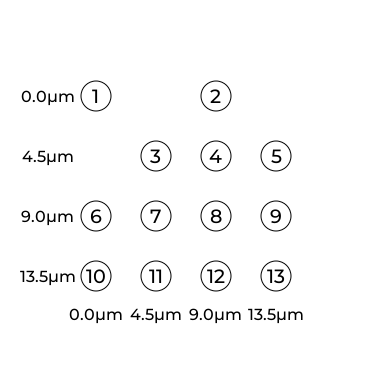

In [4]:
# Here we generate the 4*4 lattice to work with 
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

In [5]:
# With the help of classical optimization methods we get that for this specific DUGG,
# we see that the MIS size is 4, and the number of maximum independent sets is 26.  
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

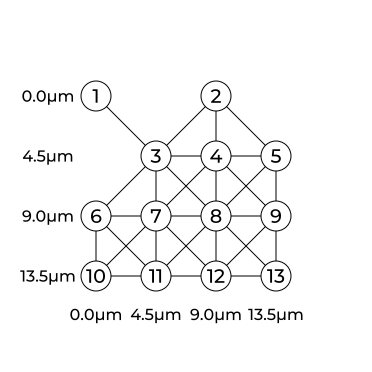

In [6]:
# Now it is possible to generate the graph for the MIS problem based on our lattice.
# We set the blockade radius to be 7.5 μm, corresponding to a case where
# nearest neighbors and next-nearest neighbors (diagonal) are within the blockade radius.
Bloqade.plot(atoms, blockade_radius = 7.5)

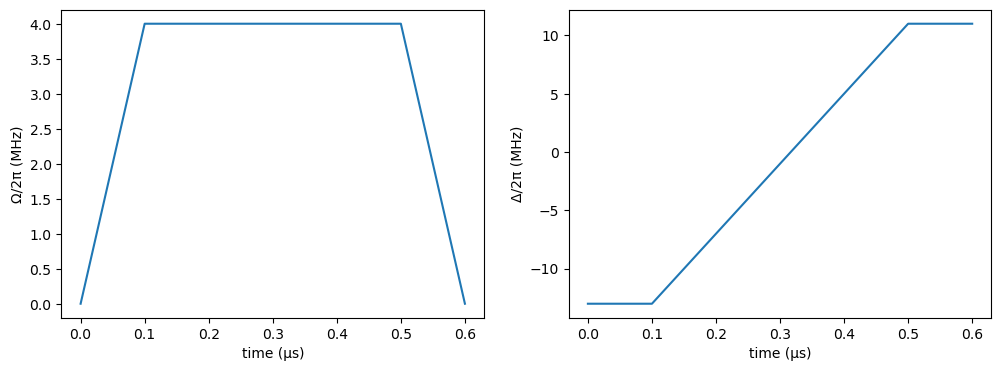

In [7]:
# Here, we generalize the quantum adiabatic algorithm used
# in the tutorial Adiabatic Evolution to prepare ground states of the 
# Rydberg Hamiltonian for this disordered lattice. We first construct the adiabatic
# pulse sequences for the Rabi frequency Ω and the detuning Δ:

T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [8]:
# Next, we create the time-dependent Hamiltonian and simulate its time 
# evolution by using the SchrodingerProblem solver:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)
# save("prob4*4.jld", "prob", prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


In [9]:
best_bit_strings = most_probable(prob.reg, 2)
best_bit_strings[1]

1001000000011 ₍₂₎

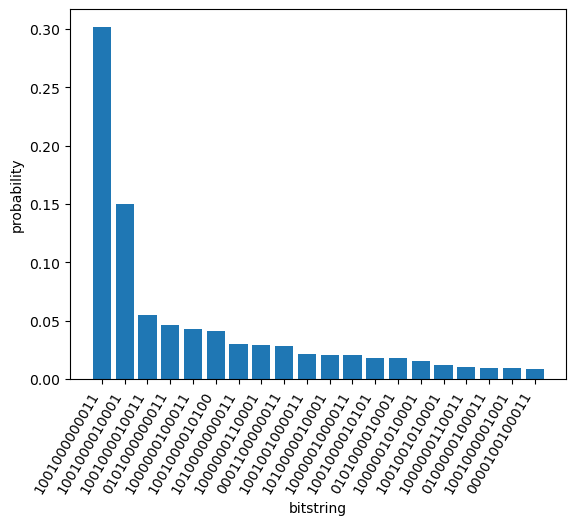

In [10]:
# Finally, we can plot the most probable bitstrings by
# using the bitstring_hist function on the resulting register (quantum state):
bitstring_hist(prob.reg; nlargest = 20)

In [11]:
# The correctness of the output can be verified by comparing it to the classical solution:
best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

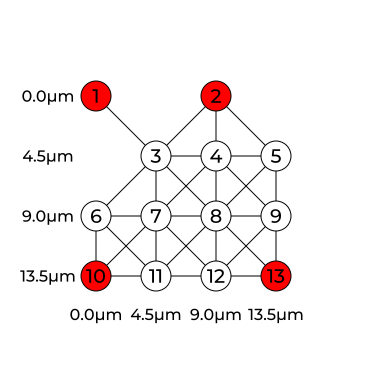

In [12]:
# Now, we can visualize our solution:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

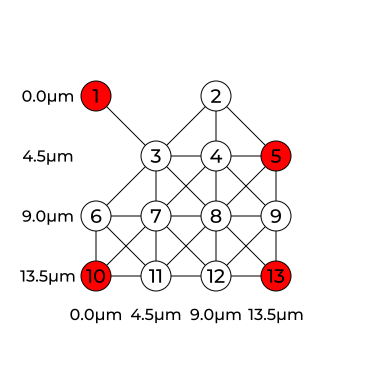

In [13]:
# The solution is not unique. Lets explore the second example. 
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

## 3.2 Bigger dimensions and different structures

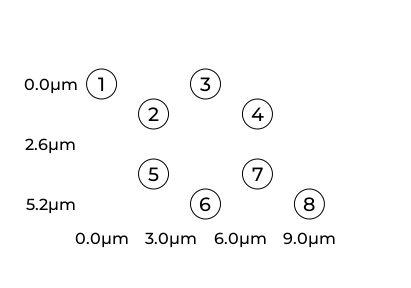

In [14]:
# Now, lets investigate different structures for the task 
atoms_honey = generate_sites(HoneycombLattice(), 2, 2; scale = 4.5)

In [15]:
graph_honey = BloqadeMIS.unit_disk_graph(atoms_honey, 5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph_honey), CountingMax())[]

(2.0, 10.0)ₜ

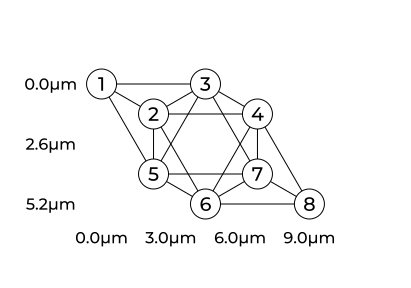

In [16]:
Bloqade.plot(atoms_honey, blockade_radius = 5)

In [17]:
hamiltonian_honey = rydberg_h(atoms_honey; Ω = Ω, Δ = Δ)
prob_honey = SchrodingerProblem(zero_state(nqubits(hamiltonian_honey)), T_max, hamiltonian_honey)
emulate!(prob_honey)
# save("prob_big.jld", "prob_big", prob_big)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 34.023 KiB
    expression:
nqubits: 8
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


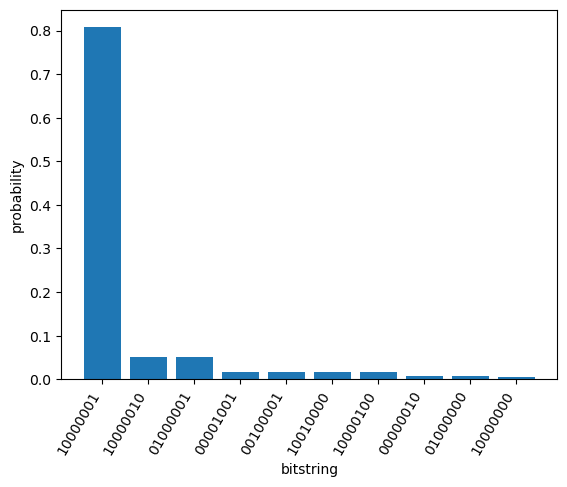

In [30]:
best_bit_string_honey = most_probable(prob_honey.reg, 2)
bitstring_hist(prob_honey.reg; nlargest = 10)

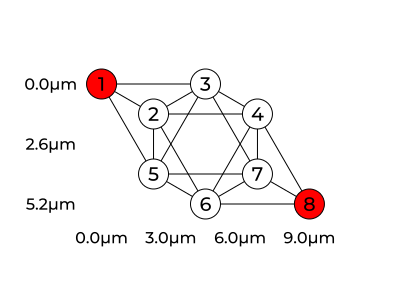

In [33]:
# The solution works fine for this model. 
Bloqade.plot(atoms_honey, blockade_radius = 5; 
    colors = [iszero(b) ? "white" : "red" for b in best_bit_string_honey[1]])

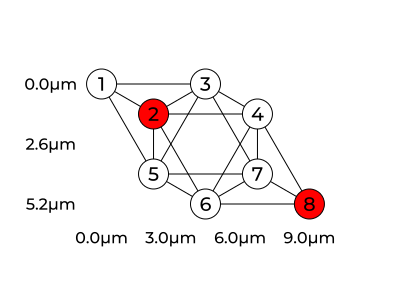

In [34]:
# The solution is not unique. Lets explore the second example. 
Bloqade.plot(atoms_honey, blockade_radius = 5; 
    colors = [iszero(b) ? "white" : "red" for b in best_bit_string_honey[2]])

Also we can improve the performance of our approach via smoothing technics. 

We will try to improve our performance using Smoothened Piecewise Linear Pulses.

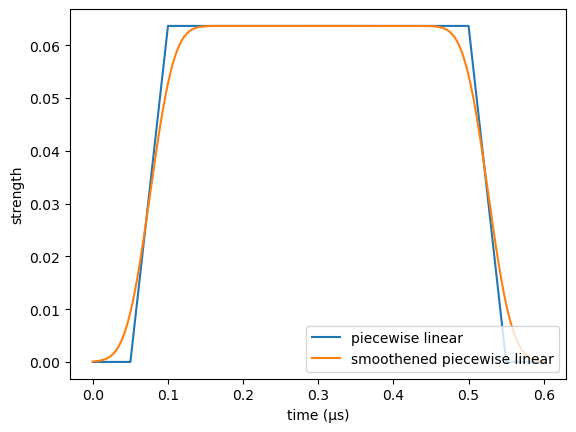

In [35]:
pulse_piecewise_linear = piecewise_linear(clocks = [0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = [0, 0, 0.4, 0.4, 0, 0]);
pulse_smooth = smooth(pulse_piecewise_linear; kernel_radius = 0.02);

fig, ax = plt.subplots()
Bloqade.plot!(ax, pulse_piecewise_linear)
Bloqade.plot!(ax, pulse_smooth)
ax.set_ylabel("strength")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

In [36]:
function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = 11 * 2π
    Δ0 = 11 * 2π
    T_max = 0.6

    # the strength of the detunings at each step takes the optimizing x as their input
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end

x0 = [0.1, 0.8, 0.8]; # initial point for the optimization

In [37]:
Δ_start = -13 * 2π
Δ_end = 11 * 2π
Δ0 = 11 * 2π
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(atoms_honey, x0)
rydberg_density

-1.6052589128060968

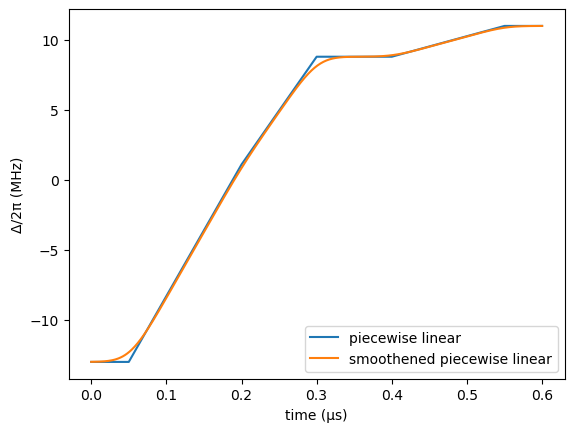

In [38]:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial)
Bloqade.plot!(ax, Δ_initial_smooth)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

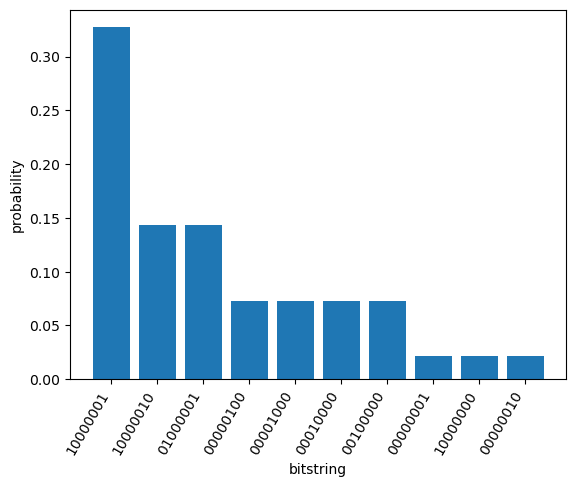

In [39]:
bitstring_hist(reg2; nlargest = 10)

In [40]:
optresult = Optim.optimize(x -> loss_piecewise_linear(atoms_honey, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(atoms_honey, optresult.minimizer)
rydberg_density_final

-1.9339104082531713

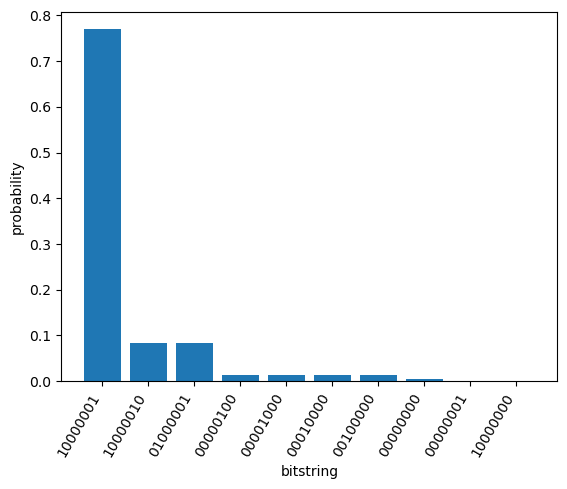

In [26]:
bitstring_hist(reg_final; nlargest = 10)

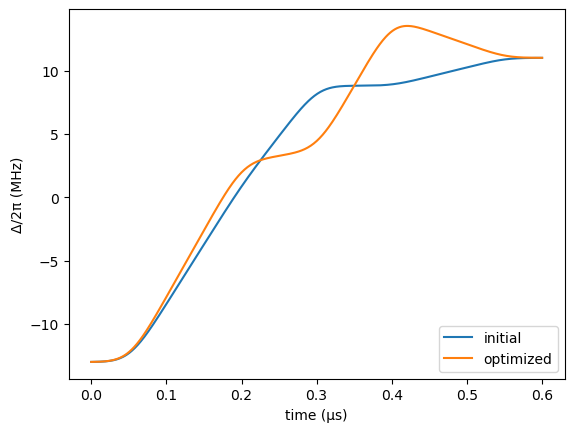

In [27]:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial_smooth)
Bloqade.plot!(ax, Δ_final)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["initial", "optimized"], loc = "lower right")
fig

As we can observe, the results has become more precise and the probability of the best solution has been improved from 0.3 to almost 0.8! Excelent result! 


However, there are a lot of problems with this model. For the simpler structure with fewer edges the solution is nor working. Lets do some calculations.

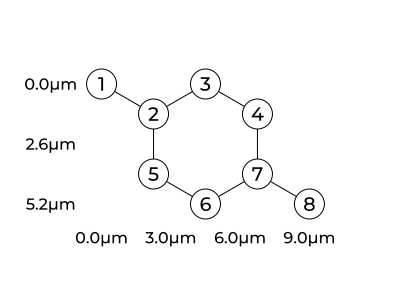

In [41]:
Bloqade.plot(atoms_honey, blockade_radius = 3)

In [42]:
hamiltonian_honey = rydberg_h(atoms_honey; Ω = Ω, Δ = Δ)
prob_honey = SchrodingerProblem(zero_state(nqubits(hamiltonian_honey)), T_max, hamiltonian_honey)
emulate!(prob_honey)
# save("prob_big.jld", "prob_big", prob_big)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 34.023 KiB
    expression:
nqubits: 8
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


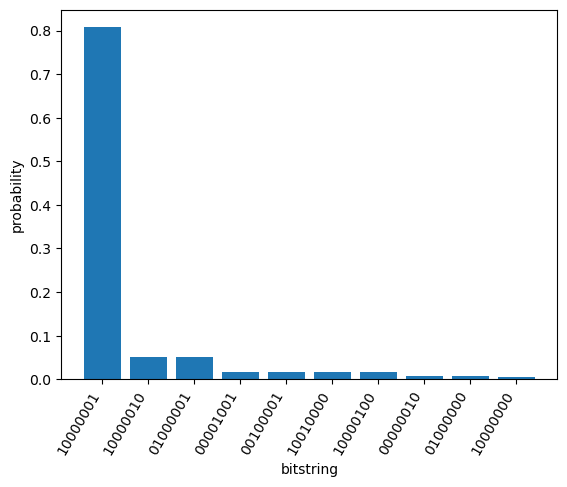

In [43]:
best_bit_string_honey = most_probable(prob_honey.reg, 2)
bitstring_hist(prob_honey.reg; nlargest = 10)

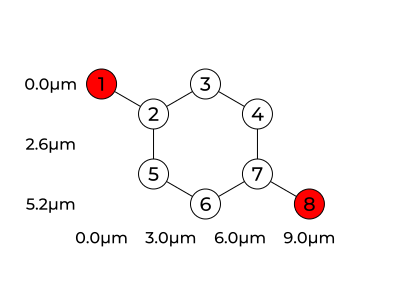

In [44]:
# The solution is not right here.
Bloqade.plot(atoms_honey, blockade_radius = 3; 
    colors = [iszero(b) ? "white" : "red" for b in best_bit_string_honey[1]])

Smoothing technics did not help here. 

For larger model with 5x5 square lattices we could not calculate the results because it took to much time for the given pulse parametrization strategy. For 2x3 size of honey structure it was also impossible to finis the simulation process.   